## Translation iwht an RNN 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

### data 

In [3]:
path = Config().data_path()
path.ls()

[PosixPath('/home/ricky/.fastai/data/giga-fren.tgz.1'),
 PosixPath('/home/ricky/.fastai/data/oxford-iiit-pet'),
 PosixPath('/home/ricky/.fastai/data/imdb'),
 PosixPath('/home/ricky/.fastai/data/imdb_sample.tgz'),
 PosixPath('/home/ricky/.fastai/data/giga-fren'),
 PosixPath('/home/ricky/.fastai/data/imdb_sample'),
 PosixPath('/home/ricky/.fastai/data/oxford-iiit-pet.tgz'),
 PosixPath('/home/ricky/.fastai/data/giga-fren.tgz'),
 PosixPath('/home/ricky/.fastai/data/human_numbers.tgz'),
 PosixPath('/home/ricky/.fastai/data/imdb.tgz'),
 PosixPath('/home/ricky/.fastai/data/human_numbers')]

In [4]:
#!wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}

In [5]:
#! tar xf {path}/giga-fren.tgz -C {path}

In [6]:
path = Config().data_path()/'giga-fren'
path.ls()

[PosixPath('/home/ricky/.fastai/data/giga-fren/models'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/cc.en.300.bin'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/questions_easy.csv'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/cc.fr.300.bin'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/data_save.pkl'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/giga-fren.release2.fixed.fr')]

In [13]:
with open(path/'giga-fren.release2.fixed.fr') as f:
    fr = f.read().split('\n')

In [14]:
with open(path/'giga-fren.release2.fixed.en') as f: 
    en = f.read().split('\n')

In [7]:
len(fr)

22520377

In [9]:
type(fr)

list

In [8]:
fr[0]

'Il a transformé notre vie | Il a transformé la société | Son fonctionnement | La technologie, moteur du changement Accueil | Concepts | Enseignants | Recherche | Aperçu | Collaborateurs | Web HHCC | Ressources | Commentaires Musée virtuel du Canada'

In [10]:
fr[1]

'Plan du site'

In [11]:
#re_eq = re.compile('^(Wh[^?.!]+\?)')
#re_fq = re.compile('^([^?.!]+\?)')
#en_fname = path/'giga-fren.release2.fixed.en'
#fr_fname = path/'giga-fren.release2.fixed.fr'

In [12]:
#re_eq.findall("What are your talking about?")

['What are your talking about?']

In [13]:
#re_eq.findall("What in the Hell")

[]

In [14]:
#re_eq.findall("What?")

['What?']

In [15]:
#lines = ((re_eq.search(eq), re_fq.search(fq)) 
#         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
#qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [16]:
#re_eq.search("What are you talking about?").group()

'What are you talking about?'

In [17]:
#qs = [(q1,q2) for q1,q2 in qs]
#df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
#df.to_csv(path/'questions_easy.csv', index=False)

In [18]:
#df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


In [15]:
path.ls()

[PosixPath('/home/ricky/.fastai/data/giga-fren/cc.en.300.bin.gz'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/questions_easy.csv'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/cc.fr.300.bin.gz'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/data_save.pkl'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/giga-fren.release2.fixed.fr')]

### Load our data into a DataBunch 

In [7]:
df = pd.read_csv(path/'questions_easy.csv')
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


In [8]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['fr'] = df['fr'].apply(lambda x:x.lower())

In [9]:
torch.tensor([[1,2,3], [4, 5, 6]]).flip(1)

tensor([[3, 2, 1],
        [6, 5, 4]])

In [10]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [29]:
doc(Dataset)

In [11]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [12]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [13]:
src = Seq2SeqTextList.from_df(df, path = path, cols='fr').split_by_rand_pct(seed=42).label_from_df(cols='en', label_cls=TextList)

In [14]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

28.0

In [15]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

23.0

In [16]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [17]:
len(src.train) + len(src.valid)

48350

In [18]:
data = src.databunch()

In [28]:
data.save()

In [29]:
data

Seq2SeqDataBunch;

Train: LabelList (38704 items)
x: Seq2SeqTextList
xxbos qu’est - ce que la lumière ?,xxbos où sommes - nous ?,xxbos d'où venons - nous ?,xxbos que ferions - nous sans elle ?,xxbos quel est le groupe autochtone principal sur l’île de vancouver ?
y: TextList
xxbos what is light ?,xxbos who are we ?,xxbos where did we come from ?,xxbos what would we do without it ?,xxbos what is the major aboriginal group on vancouver island ?
Path: /home/ricky/.fastai/data/giga-fren;

Valid: LabelList (9646 items)
x: Seq2SeqTextList
xxbos quels pourraient être les effets sur l’instrument de xxunk et sur l’aide humanitaire qui ne sont pas co - xxunk ?,xxbos quand la source primaire a - t - elle été créée ?,xxbos pourquoi tant de soldats ont - ils fait xxunk de ne pas voir ce qui s'est passé le 4 et le 16 mars ?,xxbos quels sont les taux d'impôt sur le revenu au canada pour 2007 ?,xxbos pourquoi le programme devrait - il intéresser les employeurs et les fournisseurs de services ?
y: Text

In [30]:
data.show_batch()

text,target
xxbos quelles conditions particulières doivent être remplies pendant l’examen préliminaire international en ce qui concerne les xxunk des séquences de nucléotides ou d’acides aminés ou les tableaux y relatifs ?,xxbos what special requirements apply during the international preliminary examination to nucleotide and / or amino acid sequence listings and / or tables related thereto ?
"xxbos qui a compétence pour surveiller le respect des conditions relatives au marquage : l’office de propriété industrielle , un autre organisme gouvernemental ou une entité du secteur privé ?","xxbos who is responsible for the control of marking requirements : the ip office , another government body or a private sector institution ?"
xxbos à quels xxunk le système actuel de propriété industrielle ne répond - il pas aux besoins et aux attentes de xxunk en ce qui concerne les savoirs traditionnels ?,xxbos where does the current xxunk system not meet the needs and expectations of the informant with regard to tk ?
xxbos quels sont les coûts rattachés à chacune des catégories de projets financés par le bta et comment se xxunk - ils aux projets non financés par le bta ?,xxbos what are the costs associated with each type of olt funded projects and how does it compare with non - olt projects ?
xxbos par où doit - on commencer pour soutenir ou faire avancer une approche plus holistique et plus intégrée à l’égard de la santé et des soins de santé ?,xxbos where does one begin to support or advance a more holistic and integrated approach to health and health care ?


In [19]:
path

PosixPath('/home/ricky/.fastai/data/giga-fren')

In [20]:
data = load_data(path)

In [21]:
data.show_batch()

text,target
"xxbos quels services offrez - vous aux résidents , par l'entremise de votre propre organisation , par l'entremise de liens / partenariats avec des organismes communautaires ou les deux ?",xxbos which of the following services do you offer to residents either through your own organization or through linkages and / or partnerships with community agencies or both ?
"xxbos quelles initiatives ont été prises , conformément aux recommandations précédentes du comité , pour sensibiliser tant les hommes que les femmes à la contraception et aux méthodes xxunk ?","xxbos what steps have been taken , in line with the committee ’s previous recommendations , to raise awareness about contraception and xxunk methods among both men and women ?"
xxbos qu’en est - il d’un leader qui ne possède que deux de ces caractéristiques ou de celui qui ne manifeste que de temps en temps certains comportements xxunk ?,xxbos what if a leader xxunk only two of the factors ?
"xxbos quels mécanismes d'évaluation , de surveillance ou de responsabilisation sont en place pour l'étude de cas , tant dans le cadre de l'initiative qu'à l'intérieur de votre organisation ?","xxbos what evaluation , monitoring or other accountability mechanisms are in place for this work , within the initiative and within your organization ?"
"xxbos quelles sont les hypothèses , selon la définition actuelle du développement , do nt les pays en développement sont censés s'inspirer pour réformer leurs systèmes de politique sociale ?",xxbos what are the assumptions in the current understanding of development that developing countries are expected to accommodate in reforming their social - policy systems ?


In [22]:
x, y = data.one_batch()

In [23]:
x

tensor([[   2,   19,  134,  ...,   13, 1343,    9],
        [   2,   35,  734,  ...,   13,  260,    9],
        [   2,   27,   20,  ...,   26, 1853,    9],
        ...,
        [   2,   19,   52,  ...,    1,    1,    1],
        [   2,   33,   14,  ...,    1,    1,    1],
        [   2,   24,   20,  ...,    1,    1,    1]])

In [24]:
y

tensor([[   2,   11,   15,  ...,    1,    1,    1],
        [   2,   11, 3175,  ...,  789,    9,    1],
        [   2,   11,  926,  ...,    1,    1,    1],
        ...,
        [   2,   11,   43,  ...,    1,    1,    1],
        [   2,   22,   37,  ...,    1,    1,    1],
        [   2,   11,   16,  ...,    1,    1,    1]])

In [25]:
x.shape, y.shape

(torch.Size([64, 30]), torch.Size([64, 28]))

## Pretrained Embeddings

In [26]:
import fasttext as ft

In [27]:
#! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}

In [57]:
#! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}

--2020-01-27 10:44:30--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2606:4700:10::6814:6a6, 2606:4700:10::6814:16a6, 104.20.22.166, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2606:4700:10::6814:6a6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496886212 (4.2G) [application/octet-stream]
Saving to: ‘/home/ricky/.fastai/data/giga-fren/cc.fr.300.bin.gz’

cc.fr.300.bin.gz    100%[===================>]   4.19G   304KB/s    in 1h 45m  

2020-01-27 12:29:50 (695 KB/s) - ‘/home/ricky/.fastai/data/giga-fren/cc.fr.300.bin.gz’ saved [4496886212/4496886212]



In [46]:
! gunzip {path}/cc.en.300.bin.gz

In [47]:
! gunzip {path}/cc.fr.300.bin.gz

In [28]:
path.ls()

[PosixPath('/home/ricky/.fastai/data/giga-fren/models'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/cc.en.300.bin'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/questions_easy.csv'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/cc.fr.300.bin'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/data_save.pkl'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/giga-fren.release2.fixed.fr')]

In [30]:
fr_vecs = ft.load_model(str((path/'cc.fr.300.bin')))
en_vecs = ft.load_model(str((path/'cc.en.300.bin')))

In [31]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = tensor(vec_dic[w])
        except: miss.append(w)
    return emb

In [32]:
en_vecs.get_word_vector("cat").shape

(300,)

In [33]:
# our encoder is french and decoder is english

In [34]:
emb_enc = create_emb(fr_vecs, data.x.vocab.itos)
emb_dec = create_emb(en_vecs, data.y.vocab.itos)

In [35]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([11336, 300]), torch.Size([8144, 300]))

In [36]:
model_path = Config().model_path()

In [37]:
torch.save(emb_enc, model_path/'fr_emb.pth')
torch.save(emb_dec, model_path/'en_emb.pth')

In [38]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

In [39]:
model_path.ls()

[PosixPath('/home/ricky/.fastai/models/en_emb.pth'),
 PosixPath('/home/ricky/.fastai/models/wt103-fwd.tgz'),
 PosixPath('/home/ricky/.fastai/models/wt103-fwd'),
 PosixPath('/home/ricky/.fastai/models/fr_emb.pth')]

In [40]:
??Config

## Model 

In [41]:
data.x.vocab.itos[0], data.x.vocab.itos[1], data.x.vocab.itos[2]

('xxunk', 'xxpad', 'xxbos')

In [42]:
x = torch.FloatTensor([1,2,3])
x

tensor([1., 2., 3.])

In [43]:
x.new_zeros??

In [44]:
??one_param

In [45]:
x, y = next(iter(data.train_dl))

In [46]:
x.shape, y.shape

(torch.Size([64, 30]), torch.Size([64, 29]))

In [47]:
x[0]

tensor([   2,    0,   38,  156,   10,   13,  492,   10,   46,  950,   18,   35,
         734,   25,  194, 3886, 3126,   44, 2963,    0,   40,   64, 7373,   42,
         228,  179,   10,   46,  323,    9], device='cuda:0')

In [48]:
next(iter(x))

tensor([   2,    0,   38,  156,   10,   13,  492,   10,   46,  950,   18,   35,
         734,   25,  194, 3886, 3126,   44, 2963,    0,   40,   64, 7373,   42,
         228,  179,   10,   46,  323,    9], device='cuda:0')

In [49]:
next(iter(x)).shape

torch.Size([30])

In [50]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)                     # create hidden state (2, batch_size, hidden)
        emb = self.emb_enc_drop(self.emb_enc(inp))  # grab all embeddings (batch_size, num words, embedding size)
        _, h = self.gru_enc(emb, h)                 # gru, out 
        h = self.out_enc(h)                         # final dense multiplication
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)    # add dimension to be consistent and embbed (64,1,300)
        outp, h = self.gru_dec(emb, h)              # really one operation of gru
        outp = self.out(self.out_drop(outp[:,0]))   
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)                            # final state of encoder with matrix product
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx    # create vector of first word using begin of sentance
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]                         # grab index of max prob for each value in minibatch
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break          # if all values are pad stop
        return torch.stack(res, dim=1)                       # stack them vertically
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [51]:
emb_enc.embedding_dim, emb_dec.embedding_dim

(300, 300)

In [52]:
m = Seq2SeqRNN(emb_enc, emb_dec, 256, 30)

In [53]:
bs_,sl_ = x.shape
m.initHidden(bs_).shape

torch.Size([2, 64, 256])

In [54]:
x.cpu().shape

torch.Size([64, 30])

In [55]:
m.emb_enc(x.cpu()).shape

torch.Size([64, 30, 300])

In [56]:
# encoder
bs_, sl_ = x.shape
h_ = m.initHidden(bs_)
emb_ = m.emb_enc(x.cpu())
o, h_ = m.gru_enc(emb_, h_)
h = m.out_enc(h_)

In [57]:
o.shape, h.shape # output are all the hidden states with h the last hidden state from stacked layers

(torch.Size([64, 30, 256]), torch.Size([2, 64, 300]))

the gru takes two states hidden and cell, we can check by noting the last output should be the hidden state

In [60]:
o[-1, -1, :10]

tensor([-0.0033, -0.0054, -0.0036, -0.0110,  0.0396, -0.0420,  0.0212, -0.0521,
         0.0221,  0.0238], grad_fn=<SliceBackward>)

In [61]:
h_[1,-1, :10]

tensor([-0.0033, -0.0054, -0.0036, -0.0110,  0.0396, -0.0420,  0.0212, -0.0521,
         0.0221,  0.0238], grad_fn=<SliceBackward>)

In [62]:
np.allclose(o[-1,-1], h_[1,-1])

True

In [63]:
# decoder
din = x.new_zeros(bs_).long() + m.bos_idx
demb = m.emb_dec(din.cpu())

In [64]:
demb.shape

torch.Size([64, 300])

In [65]:
demb.unsqueeze(1).shape

torch.Size([64, 1, 300])

In [66]:
# decoder
din = x.new_zeros(bs_).long() + m.bos_idx
demb = m.emb_dec(din.cpu()).unsqueeze(1)
dout, dh = m.gru_dec(demb, h)
dout_ = m.out(dout[:,0])

In [67]:
dout.shape, dh.shape

(torch.Size([64, 1, 300]), torch.Size([2, 64, 300]))

In [68]:
np.allclose(dout[-1,0], dh[1,-1])

True

In [69]:
dout[:,0].shape

torch.Size([64, 300])

In [70]:
dout_.shape

torch.Size([64, 8144])

In [71]:
dout_.max(1)

torch.return_types.max(
values=tensor([3.8413, 4.3012, 3.7528, 2.9842, 3.7418, 3.9201, 3.8199, 3.8749, 4.4723,
        3.5476, 3.5504, 3.9011, 3.6148, 3.7285, 3.8279, 3.3109, 3.7047, 3.6460,
        4.0895, 3.8533, 3.7787, 3.8646, 3.8204, 3.8274, 3.9406, 3.0696, 3.9806,
        3.6097, 3.1122, 3.6734, 3.5935, 4.4250, 3.6849, 3.6182, 3.2588, 4.5340,
        3.2302, 3.4105, 4.3166, 4.0195, 3.3291, 3.7371, 3.3461, 4.0605, 3.9252,
        3.7012, 3.7711, 3.5000, 3.6321, 3.3872, 3.4726, 3.7015, 3.6201, 3.3703,
        3.8814, 3.2467, 3.1659, 3.2000, 3.4263, 3.5946, 3.6476, 3.5742, 3.3634,
        3.5263], grad_fn=<MaxBackward0>),
indices=tensor([5808, 5211, 5808, 7533, 5808, 5808, 5211, 5808, 5808, 5808, 5808, 5808,
        5675, 5211, 5808, 5808, 5808, 5211, 5808, 5808, 5808, 7533, 5808, 5808,
        5808, 5675, 5808, 5808, 5675, 5808, 5808, 5808, 5808, 5808, 5808, 5808,
        7575, 5808, 5808, 5808, 7533, 5808, 7533, 5808, 5808, 5808, 5808, 5808,
        5808, 5808, 5808, 5808, 5808, 5

In [72]:
dout_.max(1)[1]

tensor([5808, 5211, 5808, 7533, 5808, 5808, 5211, 5808, 5808, 5808, 5808, 5808,
        5675, 5211, 5808, 5808, 5808, 5211, 5808, 5808, 5808, 7533, 5808, 5808,
        5808, 5675, 5808, 5808, 5675, 5808, 5808, 5808, 5808, 5808, 5808, 5808,
        7575, 5808, 5808, 5808, 7533, 5808, 7533, 5808, 5808, 5808, 5808, 5808,
        5808, 5808, 5808, 5808, 5808, 5808, 5808, 5808, 5211, 5675, 5808, 5808,
        5808, 5808, 5808, 7533])

In [73]:
torch.stack([torch.FloatTensor([1,2,3]), torch.FloatTensor([4,5,6])], dim=1)

tensor([[1., 4.],
        [2., 5.],
        [3., 6.]])

In [74]:
xb, yb = next(iter(data.valid_dl))

In [75]:
xb.shape

torch.Size([64, 30])

In [76]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 30)

In [77]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(11336, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(8144, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=8144, bias=True)
)

In [78]:
len(xb[0])

30

In [79]:
h = rnn.encoder(64, xb.cpu())

In [80]:
h.size()

torch.Size([2, 64, 300])

In [81]:
rnn(xb.cpu()).shape, y.shape

(torch.Size([64, 30, 8144]), torch.Size([64, 29]))

In [180]:
??F.pad

In [83]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [85]:
??FlattenedLoss

## Train model 

In [86]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

In [87]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


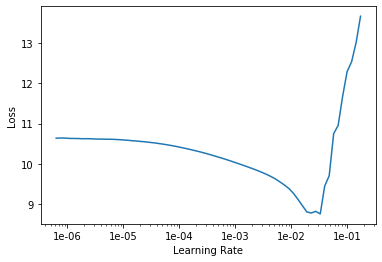

In [88]:
learn.recorder.plot()

In [89]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,time
0,5.599557,4.543440,00:32
1,5.159997,5.758074,00:30
2,4.492152,5.159544,00:32
3,3.717603,4.475745,00:33


In [90]:
del fr_vecs
del en_vecs

In [92]:
xb.shape

torch.Size([64, 30])

In [91]:
torch.Tensor([[[0,1], [0,3]]]).shape

torch.Size([1, 2, 2])

In [96]:
torch.Tensor([[[.8,.2], [.2,.8]]]).argmax(-1) # get inex of word with max value

tensor([[0, 1]])

In [97]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

## Bleu Metric 

In [98]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [99]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [100]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [101]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

## Training with metrics 

In [102]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])

In [103]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


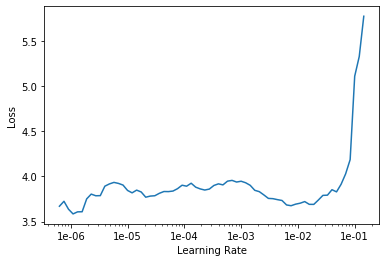

In [104]:
learn.recorder.plot()

In [106]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.239183,5.441340,0.268645,0.233765,00:39
1,4.220284,5.093105,0.298995,0.237648,00:38
2,4.008147,4.555740,0.352873,0.273893,00:39
3,3.183113,4.081397,0.401639,0.304101,00:40


In [107]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.923152,3.928643,0.417162,0.312380,00:42
1,2.851885,3.822993,0.427842,0.321147,00:42
2,2.643012,3.755877,0.435341,0.326290,00:43
3,2.462363,3.708637,0.441953,0.332545,00:43


In [119]:
learn.model.eval()
with torch.no_grad():
    xb, yb = data.one_batch()
    w = learn.model(xb.cuda())
    print(w.shape, w.argmax(2).shape)

torch.Size([64, 30, 8144]) torch.Size([64, 30])


In [127]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [], [], []
    with torch.no_grad():
        for xb, yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x, y, z in zip(xb, yb, out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [128]:
inputs, targets, outputs = get_predictions(learn)

In [129]:
inputs[700], targets[700], outputs[700]

(Text xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?,
 Text xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?,
 Text xxbos who is the the the the and and and and and ? ?)

In [130]:
inputs[701], targets[701], outputs[701]

(Text xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?,
 Text xxbos what happened to their great xxunk about transparency and accountability ?,
 Text xxbos what are the key and and and and and and ? ?)

In [131]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos quelles sont les deux tendances qui ont nuit à la pêche au saumon dans cette province ?,
 Text xxbos what two trends negatively affected the province ’s salmon fishery ?,
 Text xxbos what are the trends trends the the the the in in in the ? ?)

In [132]:
inputs[4000], targets[4000], outputs[4000]

(Text xxbos où les aires marines nationales de conservation du canada seront - elles situées ?,
 Text xxbos where will national marine conservation areas of canada be located ?,
 Text xxbos where are the national areas areas of areas in located located ? ?)